In [1]:
#导入相关依赖库
import  os
import numpy as np
from matplotlib import pyplot as plt

import mindspore as ms
#context模块用于设置实验环境和实验设备
import mindspore.context as context
#dataset模块用于处理数据形成数据集
import mindspore.dataset as ds
#c_transforms模块用于转换数据类型
import mindspore.dataset.transforms.c_transforms as C
#vision.c_transforms模块用于转换图像，这是一个基于opencv的高级API
import mindspore.dataset.vision.c_transforms as CV
#导入Accuracy作为评价指标
from mindspore.nn.metrics import Accuracy
#nn中有各种神经网络层如：Dense，ReLu
from mindspore import nn
#Model用于创建模型对象，完成网络搭建和编译，并用于训练和评估
from mindspore.train import Model
#LossMonitor可以在训练过程中返回LOSS值作为监控指标
from mindspore.train.callback import  LossMonitor
#设定运行模式为动态图模式，并且运行设备为昇腾芯片
context.set_context(mode=context.GRAPH_MODE, device_target='Ascend') 


In [3]:
#MindSpore内置方法读取MNIST数据集
ds_train = ds.MnistDataset(os.path.join(r'./MNIST', "train"))
ds_test = ds.MnistDataset(os.path.join(r'./MNIST', "test")) 

print('训练数据集数量：',ds_train.get_dataset_size())
print('测试数据集数量：',ds_test.get_dataset_size())
#该数据集可以通过create_dict_iterator()转换为迭代器形式，然后通过__next__()一个个输出样本
image=ds_train.create_dict_iterator().__next__()
print(type(image))
print('图像长/宽/通道数：',image['image'].shape)
#一共10类，用0-9的数字表达类别。
print('一张图像的标签样式：',image['label'])  


训练数据集数量： 60000
测试数据集数量： 10000
<class 'dict'>
图像长/宽/通道数： (28, 28, 1)
一张图像的标签样式： 1


In [4]:
DATA_DIR_TRAIN = "./MNIST/train" # 训练集信息
DATA_DIR_TEST = "./MNIST/test" # 测试集信息

def create_dataset(training=True, batch_size=128, resize=(28, 28),rescale=1/255, shift=-0.5, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    
    #定义改变形状、归一化和更改图片维度的操作。
    #改为（28,28）的形状
    resize_op = CV.Resize(resize)
    #rescale方法可以对数据集进行归一化和标准化操作，这里就是将像素值归一到0和1之间，shift参数可以让值域偏移至-0.5和0.5之间
    rescale_op = CV.Rescale(rescale, shift)
    #由高度、宽度、深度改为深度、高度、宽度
    hwc2chw_op = CV.HWC2CHW()
    
    # 利用map操作对原数据集进行调整
    ds = ds.map(input_columns="image", operations=[resize_op, rescale_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    #设定洗牌缓冲区的大小，从一定程度上控制打乱操作的混乱程度
    ds = ds.shuffle(buffer_size=buffer_size)
    #设定数据集的batch_size大小，并丢弃剩余的样本
    ds = ds.batch(batch_size, drop_remainder=True)
    
    return ds


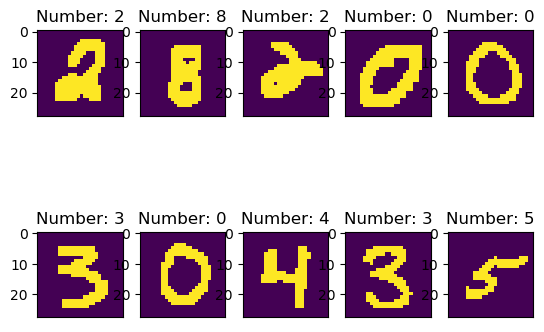

In [5]:
#显示前10张图片以及对应标签,检查图片是否是正确的数据集
dataset_show = create_dataset(training=False)
data = dataset_show.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()

for i in range(1,11):
    plt.subplot(2, 5, i)
    #利用squeeze方法去掉多余的一个维度
    plt.imshow(np.squeeze(images[i]))
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()


In [6]:
#利用定义类的方式生成网络，Mindspore中定义网络需要继承nn.cell。在init方法中定义该网络需要的神经网络层
#在construct方法中梳理神经网络层与层之间的关系。
class ForwardNN(nn.Cell):      
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(784, 512, activation='relu')
        self.fc2 = nn.Dense(512, 256, activation='relu')
        self.fc3 = nn.Dense(256, 128, activation='relu')
        self.fc4 = nn.Dense(128, 64, activation='relu')
        self.fc5 = nn.Dense(64, 32, activation='relu')
        self.fc6 = nn.Dense(32, 10, activation='softmax')
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)   
        output = self.fc4(output)
        output = self.fc5(output)
        output = self.fc6(output)
        return output 


In [7]:
lr = 0.001
num_epoch = 10
momentum = 0.9

net = ForwardNN()
#定义loss函数，改函数不需要求导，可以给离散的标签值，且loss值为均值
loss = nn.loss.SoftmaxCrossEntropyWithLogits( sparse=True, reduction='mean')
#定义准确率为评价指标，用于评价模型
metrics={"Accuracy": Accuracy()}
#定义优化器为Adam优化器，并设定学习率
opt = nn.Adam(net.trainable_params(), lr)


In [8]:
#生成验证集，验证机不需要训练，所以不需要repeat
ds_eval = create_dataset(False, batch_size=32)
#模型编译过程，将定义好的网络、loss函数、评价指标、优化器编译
model = Model(net, loss, opt, metrics)

#生成训练集
ds_train = create_dataset(True, batch_size=32)
print("============== Starting Training ==============")
#训练模型，用loss作为监控指标，并利用昇腾芯片的数据下沉特性进行训练
model.train(num_epoch, ds_train,callbacks=[LossMonitor()],dataset_sink_mode=True)


============== Starting Training ==============
epoch: 1 step: 1875, loss is 1.6748307
epoch: 2 step: 1875, loss is 1.6553694
epoch: 3 step: 1875, loss is 1.6783557
epoch: 4 step: 1875, loss is 1.866499
epoch: 5 step: 1875, loss is 1.7089926
epoch: 6 step: 1875, loss is 1.8976259
epoch: 7 step: 1875, loss is 1.6799028
epoch: 8 step: 1875, loss is 1.5863123
epoch: 9 step: 1875, loss is 1.7111486
epoch: 10 step: 1875, loss is 1.6174002


In [9]:
#使用测试集评估模型，打印总体准确率
metrics_result=model.eval(ds_eval)
print(metrics_result)


{'Accuracy': 0.7682291666666666}
